In [5]:
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import io, color
from skimage.transform import resize
import math


In [28]:
img_dir = "./data/downloaded/ericcahan/Farallon Island, CA - Sunset 4:49pm.jpg"

In [29]:
def get_df_rgb(img):
    image = img
    if isinstance(img, str):
        image = Image.open(img)
    
    n_dims = np.array(image).shape[-1]
    r, g, b = np.array(image).reshape(-1, n_dims).T
    # return pd.DataFrame({'r': r, 'g': g, 'b': b}).sample(n=sample_size)
    return pd.DataFrame({'r': r, 'g': g, 'b': b})
    

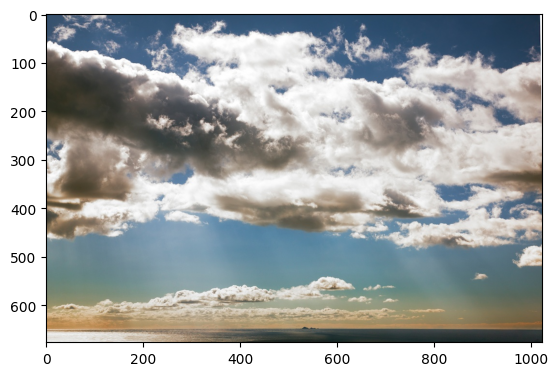

(693248, 3)


In [30]:
File_name = mpimg.imread(img_dir)
plt.imshow(File_name)
plt.show()

# plt.imshow(image)
# image.show()
rgb_values = get_df_rgb(File_name)
print(rgb_values.shape)

In [31]:
rgb_array = rgb_values.values

# Initialize the PCA model with 2 components
pca = PCA(n_components=2)

# Fit the PCA model to your data
pca.fit(rgb_array)

# Transform the RGB values to the first two principal components
pca_components = pca.transform(rgb_array)


Sort rgb values according to pca_1 value

In [32]:
pca_1 = pca_components[:,0]
sorted_pca_1_indices = np.argsort(pca_1)
sorted_pca_1 = pca_1[sorted_pca_1_indices]
sorted_pca_colors = rgb_array[sorted_pca_1_indices]

In [33]:
num_colors = 5

min_pca_value = sorted_pca_1[0]
max_pca_value = sorted_pca_1[-1]

pca_value_stops = np.linspace(min_pca_value, max_pca_value, num_colors + 1)

previous_value = min_pca_value  # Initialize with the minimum value
accumulated_count = 0

sections = []
for i, value in enumerate(pca_value_stops):
    if i == 0:
        continue
    else:
        condition = None
        if i == len(pca_value_stops) - 1:
            condition = (previous_value <= pca_1) & (pca_1 <= value)
        else:
            condition = (previous_value <= pca_1) & (pca_1 < value)
        pca_values_in_section = pca_1[condition]
        original_indices = np.array(range(len(pca_values_in_section))) + accumulated_count

        sections.append({
            "pca_values": pca_values_in_section,
            "original_indices": original_indices,
        })
        print(f"Section {i}: {previous_value} to {value}")
        print(f"Number of images: {len(pca_values_in_section)}")
        print()
        accumulated_count += len(pca_values_in_section)
        previous_value = value  # Update previous_section for the next iteration



Section 1: -180.0287150112907 to -94.50469199770453
Number of images: 162895

Section 2: -94.50469199770453 to -8.980668984118353
Number of images: 129898

Section 3: -8.980668984118353 to 76.54335402946779
Number of images: 234489

Section 4: 76.54335402946779 to 162.067377043054
Number of images: 142364

Section 5: 162.067377043054 to 247.5914000566402
Number of images: 23602



In [34]:
print(sections[-1]["original_indices"][-1])

693247


In [35]:
# sections[0]["pca_values"]
sections[0]["original_indices"]

array([     0,      1,      2, ..., 162892, 162893, 162894])

In [36]:
key_colors = []


for i in range(len(sections)):
    section = sections[i]
    original_indices = section['original_indices']
    median_index = int(len(original_indices) / 2)
    original_index = original_indices[median_index]
    key_colors.append(rgb_array[original_index])

    
print(key_colors)


[array([ 79, 106, 136], dtype=uint8), array([204, 197, 191], dtype=uint8), array([124, 118, 102], dtype=uint8), array([200, 193, 175], dtype=uint8), array([53, 62, 57], dtype=uint8)]


In [37]:
def create_color_gradient_key_colors(key_colors, gradient_width, gradient_height):
    # gradient_colors = calculate_intermediate_colors(key_colors, len(key_colors))
    gradient_colors = [tuple(color) for color in key_colors]
    
    gradient_palette = Image.new("RGB", (gradient_width, gradient_height))
    draw = ImageDraw.Draw(gradient_palette)
    
    color_width = gradient_width / len(gradient_colors)
    for i, color in enumerate(gradient_colors):
        draw.rectangle([(i * color_width, 0), ((i + 1) * color_width, gradient_height)], fill=color)
    
    return gradient_palette


In [38]:
gradient_image = create_color_gradient_key_colors(key_colors, 1000, 100)
gradient_image.show()

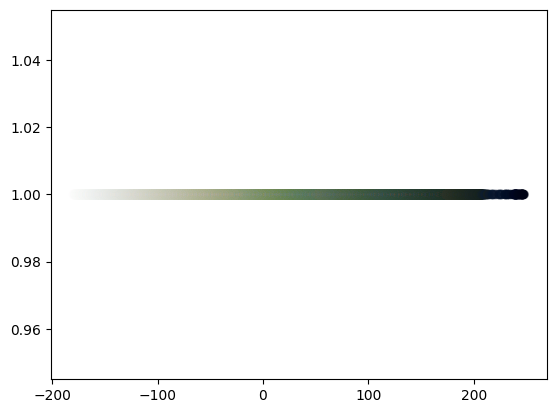

In [39]:
# Check if the sorted works well
one_dim = pca_components[:, 0]
# plt.scatter(one_dim, np.zeros_like(one_dim), c=rgb_array/255.0, alpha=0.5)
plt.scatter(sorted_pca_1, np.ones_like(sorted_pca_1), c=sorted_pca_colors/255.0, alpha=0.5)
plt.show()


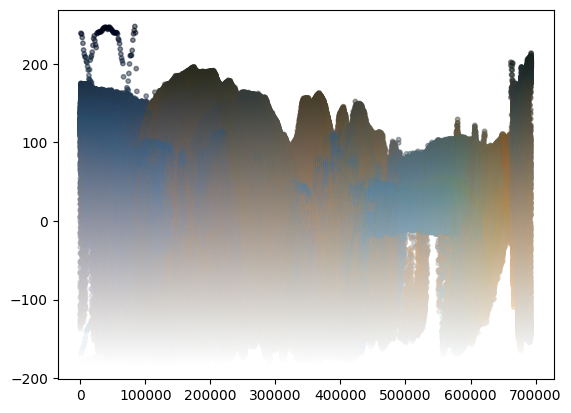

In [40]:
plt.scatter(range(len(one_dim)), one_dim, c=rgb_array/255.0, alpha=0.5, s=10)
plt.show()

In [41]:
print(pca_components)

[[124.43006766 -24.93818981]
 [122.70286285 -25.06664085]
 [122.70286285 -25.06664085]
 ...
 [199.96027189  11.13734943]
 [199.96027189  11.13734943]
 [205.14188631  11.52270255]]


In [42]:
len(pca_components)
first_component = pca_components[:, 0]
first_component.shape

(693248,)

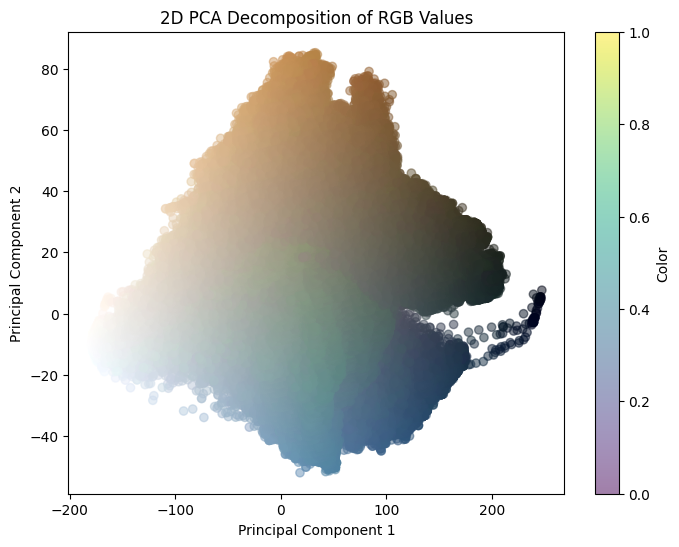

In [43]:
# Create a DataFrame for the transformed PCA components
pca_df = pd.DataFrame(data=pca_components, columns=['PC1', 'PC2'])

# Plot the 2D PCA decomposition with colored points
plt.figure(figsize=(8, 6))
plt.scatter(pca_df['PC1'], pca_df['PC2'], c=rgb_array/255.0, alpha=0.5)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('2D PCA Decomposition of RGB Values')
plt.colorbar(label='Color')
plt.show()

In [21]:
from sklearn.cluster import KMeans

palette_size = 5
model = KMeans(n_clusters=palette_size)
clusters = model.fit_predict(rgb_values)

palette = model.cluster_centers_.astype(int).tolist()

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [22]:
ndArray = np.array(palette, dtype=np.float32)
outImg = Image.fromarray(ndArray)
# outImg.save('./image.jpg')
print(ndArray)


[[  3.  78. 134.]
 [178. 184. 192.]
 [240. 163. 126.]
 [ 89. 140. 177.]
 [151.  91. 105.]]


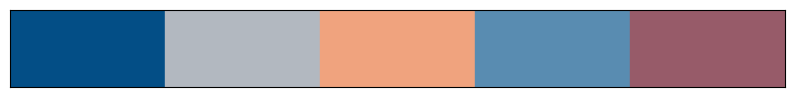

In [23]:
# Create a figure and axis
fig, ax = plt.subplots(figsize=(10, 1))

# Set axis limits
ax.set_xlim(0, len(palette))
ax.set_ylim(0, 1)

# Remove axis labels and ticks
ax.set_xticks([])
ax.set_yticks([])

# Create colored squares for each RGB value
for i, rgb in enumerate(palette):
    color = [comp / 255.0 for comp in rgb]  # Normalize to [0, 1] range
    ax.add_patch(plt.Rectangle((i, 0), 1, 1, color=color))

# Display the color row
plt.show()

In [24]:
from PIL import Image, ImageDraw
import numpy as np
from sklearn.cluster import KMeans
from scipy.spatial.distance import euclidean


def calculate_intermediate_colors(colors, num_colors):
    gradient_colors = []
    
    for i in range(num_colors):
        t = i / (num_colors - 1)
        interpolated_color = tuple(int(colors[0][c] * (1 - t) + colors[1][c] * t) for c in range(3))
        gradient_colors.append(interpolated_color)
    
    return gradient_colors

def extract_key_colors_kmeans(image_path, num_colors):
    image = Image.open(image_path)
    image_array = np.array(image)

    
    h, w, d = image_array.shape
    image_flatten = image_array.reshape(h * w, d)
    # Initialize the PCA model with 1 component
    pca_1 = PCA(n_components=1)
    # Fit the PCA model to your data
    pca_1.fit(image_flatten)
    # Transform the RGB values to the first one principal component
    pca_1_components = pca_1.transform(image_flatten)
    
    sorted_pca_1_indices = np.argsort(pca_1_components[:, 0])
    sorted_pca_1 = pca_1_components[sorted_pca_1_indices]

    # sort the colors by the pca_1_components
    image_flatten = image_flatten[sorted_pca_1_indices]

    kmeans = KMeans(n_clusters=num_colors, random_state=0)
    kmeans.fit(image_flatten)
    cluster_centers = kmeans.cluster_centers_

    key_colors = []

    temp_colors = []
    for i in range(num_colors):
        cluster_pts = image_flatten[kmeans.labels_ == i]
        cluster_pts_indices = np.where(kmeans.labels_ == i)[0]
        cluster_cen = cluster_centers[i]
        cluster_mean = np.mean(cluster_pts, axis=0)
    
        # min_idx = np.argmin([euclidean(image_flatten[idx], cluster_cen) for idx in cluster_pts_indices])
        # temp_colors.append({
        #     "idx": cluster_pts_indices[min_idx],
        #     "color": image_flatten[cluster_pts_indices[min_idx]]
        # })
        # key_colors.append(image_flatten[cluster_pts_indices[min_idx]])
        print(cluster_mean)
        key_colors.append(cluster_mean.astype(int))
    
    # temp_colors = sorted(temp_colors, key=lambda x: x["idx"])
    # print(temp_colors)
    # key_colors = [color["color"] for color in temp_colors]

    # key_colors = cluster_centers.astype(int)

    
    return key_colors

def create_color_gradient_key_colors(key_colors, gradient_width, gradient_height):
    # gradient_colors = calculate_intermediate_colors(key_colors, len(key_colors))
    gradient_colors = [tuple(color) for color in key_colors]
    
    gradient_palette = Image.new("RGB", (gradient_width, gradient_height))
    draw = ImageDraw.Draw(gradient_palette)
    
    color_width = gradient_width / len(gradient_colors)
    for i, color in enumerate(gradient_colors):
        draw.rectangle([(i * color_width, 0), ((i + 1) * color_width, gradient_height)], fill=color)
    
    return gradient_palette

# input_image_path = "./data/downloaded/ericcahan/Alamar, Ciudad De La Habana, Cuba - Sunset 8:11pm.jpg"
# input_image_path = "./data/Lenna.png"
output_gradient_width = 1000
output_gradient_height = 100
num_colors_in_gradient = 5

key_colors = extract_key_colors_kmeans(img_dir, num_colors_in_gradient)
gradient_image = create_color_gradient_key_colors(key_colors, output_gradient_width, output_gradient_height)
gradient_image.show()

/Users/hunkim/anaconda3/envs/gan/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


[  3.2995581   78.26719093 134.25165851]
[178.2841129  183.97729718 192.23299365]
[240.74002232 163.6999762  126.47955636]
[ 88.14056264 139.79832568 177.4323309 ]
[151.03896385  91.80726245 105.94310138]
